# Tweet Semantic Analysis

A simple tweet sentiment classification using pretrained [GloVe word vectors](https://nlp.stanford.edu/projects/glove/) simple convolutional neural network. Network is roughly inspired by article [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882). Dataset is trained and tested with [Sentiment Analysis Dataset](http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/) which contains 1,578,627 classified tweets, each row is marked as 1 for positive sentiment and 0 for negative sentiment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import csv

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input,  Flatten
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling1D, Embedding, LSTM
from keras.models import load_model

import gensim
from gensim.models.word2vec import Word2Vec 

import nltk

import warnings
warnings.filterwarnings('ignore')

/u/58/edamskag/unix/tensorflow/plants/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data from Sentiment Analysis Dataset.csv

In [2]:
x = []
y = []
with open("Sentiment Analysis Dataset.csv", "rt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        is_positive = line[1]=="1"
        text = line[3]
        x.append(text)
        y.append(is_positive)

data = pd.read_csv('Sentiment Analysis Dataset.csv', error_bad_lines=False)
data.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)
print('dataset loaded with shape', data.shape) 

# Function for tokenizing data

In [3]:
number_of_words=50000
max_sequence_length = 20
def tokenize_data(x_raw, y_raw):
    tokenizer = Tokenizer(nb_words=number_of_words)
    tokenizer.fit_on_texts(x_raw)
    sequences = tokenizer.texts_to_sequences(x_raw)
    word_index = tokenizer.word_index
    x_processed = pad_sequences(sequences, maxlen=max_sequence_length)
    y_processed = to_categorical(np.asarray(y_raw), 2)

    return x_processed, y_processed, word_index


In [4]:
x_processed, y_processed, word_index = tokenize_data(x,y)

# Shuffle data and split it for training and testing

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_processed, y_processed, test_size = 0.1, random_state=1)

# Glove embeddings

In [6]:
embedding_dimension = 200
glove_directory="./glove/"
glove_file="glove.twitter.27B.200d.txt"
def get_embeddings():
    embeddings = {}
    with open(os.path.join(glove_directory, glove_file), 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
    return embeddings

# Embeddings layer

In [7]:
def embedding_layer(word_index):
    embeddings = get_embeddings()
    nb_words = min(number_of_words, len(word_index))
    embedding_matrix = np.zeros((nb_words, embedding_dimension))
    for word, i in word_index.items():
        if i >= number_of_words:
            continue
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(input_dim=nb_words, output_dim=embedding_dimension, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)
    return embedding_layer

In [8]:
def create_model(labels_index, word_index):
    embedded_sequences = embedding_layer(word_index)
    model = Sequential([
        embedded_sequences,
        Conv1D(nb_filter=128, filter_length=3, padding='same', activation='relu'),
        MaxPooling1D(pool_length=1),
        Conv1D(nb_filter=128, filter_length=4, padding='same', activation='relu'),
        MaxPooling1D(pool_length=1),
        Dropout(0.4),
        Flatten(),
        Dense(len(labels_index), activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

In [9]:
labels_index = { 'Negative': 0, 'Positive': 1}
model = create_model(labels_index, word_index)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 200)           10000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           76928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 128)           65664     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
__________

In [10]:
batch_size = 256
epochs = 10
History=model.fit(x_train, y_train, validation_split=0.1, epochs=epochs,batch_size=batch_size,verbose=1)
model.save_weights('weights.h5')
model.save("model.h5")

Train on 1278677 samples, validate on 142076 samples
Epoch 1/10
1278677/1278677 [==============================] - 37s 29us/step - loss: 0.4408 - acc: 0.7951 - val_loss: 0.4135 - val_acc: 0.8106
Epoch 2/10
1278677/1278677 [==============================] - 36s 28us/step - loss: 0.4114 - acc: 0.8127 - val_loss: 0.4045 - val_acc: 0.8169
Epoch 3/10
1278677/1278677 [==============================] - 36s 28us/step - loss: 0.4016 - acc: 0.8186 - val_loss: 0.4039 - val_acc: 0.8177
Epoch 4/10
1278677/1278677 [==============================] - 37s 29us/step - loss: 0.3950 - acc: 0.8220 - val_loss: 0.4000 - val_acc: 0.8188
Epoch 5/10
1278677/1278677 [==============================] - 36s 28us/step - loss: 0.3894 - acc: 0.8250 - val_loss: 0.4014 - val_acc: 0.8191
Epoch 6/10
1278677/1278677 [==============================] - 36s 28us/step - loss: 0.3854 - acc: 0.8272 - val_loss: 0.4037 - val_acc: 0.8170
Epoch 7/10
1278677/1278677 [==============================] - 36s 28us/step - loss: 0.3815 - ac

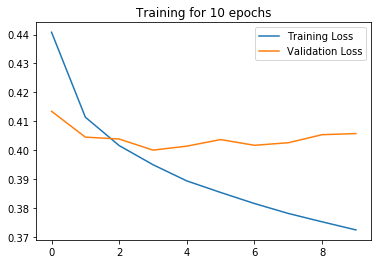

In [11]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

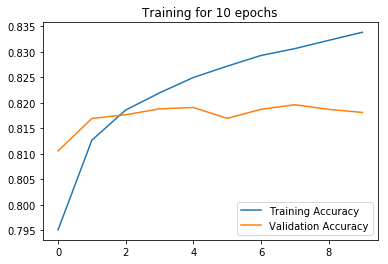

In [12]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [13]:
model.evaluate(x_test,y_test, batch_size=128)

157862/157862 [==============================] - 3s 20us/step


[0.4092599625146819, 0.8165232925027739]

# Model gives test accuracy 81,7%.